<a href="https://colab.research.google.com/github/raflyamanta/live-vote-ml/blob/main/LivenessDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
%pip install labelme tensorflow opencv-python matplotlib albumentations cv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


### 1.2 Collect Images Using OpenCV

In [ ]:
import os
import time
import uuid
import cv2

In [ ]:
IMAGES_PATH = os.path.join('dataset','all')

In [ ]:
# cap = cv2.VideoCapture(0)
# for imgnum in range(number_images):
#     print('Collecting image {}'.format(imgnum))
#     ret, frame = cap.read()
#     imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
#     cv2.imwrite(imgname, frame)
#     cv2.imshow('frame', frame)
#     time.sleep(0.5)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [ ]:
!labelme

In [ ]:
!pip install cvzone

  Preparing metadata (setup.py) ... done
  Created wheel for cvzone: filename=cvzone-1.6.1-py3-none-any.whl size=26298 sha256=f6de70a78312f05a0d0ef4c971117d84301ddbcf5bc3943f216eca750fb909ed
  Stored in directory: /root/.cache/pip/wheels/2c/9f/b3/92e945ac4a71bf727a92463f38155cc5a4fa49c5010b38ec4c
Successfully built cvzone


In [ ]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         1.1.1
aiohappyeyeballs                   2.4.4
aiohttp                            3.11.9
aiosignal                          1.3.1
alabaster                          1.0.0
albucore                           0.0.19
albumentations                     1.4.20
altair                             4.2.2
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.20.0
astropy                            6.1.7
astropy-iers-data                  0.2024.12.2.0.35.34
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic                           4.1.0
attrs                              24.2.0
audioread           

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [ ]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [ ]:
gpu_devices = tf.config.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)


### 2.3 Load Image into TF Data Pipeline

In [ ]:
jpg_images = tf.data.Dataset.list_files('/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/all/*.jpg', shuffle=False)
png_images = tf.data.Dataset.list_files('/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/all/*.png', shuffle=False)

images = jpg_images.concatenate(png_images)

In [ ]:
images.as_numpy_iterator().next()

b'/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/all/-0bd9d8c90c1199961a5970e392c7309e_jpg.rf.5f3f585435f2a3ecd3c27c1fc80d076d.jpg'

In [ ]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)

array([[[140, 150, 152],
        [140, 150, 152],
        [140, 150, 152],
        ...,
        [154, 165, 149],
        [156, 167, 153],
        [157, 168, 154]],

       [[140, 150, 152],
        [140, 150, 152],
        [140, 150, 152],
        ...,
        [152, 165, 148],
        [154, 166, 152],
        [155, 167, 153]],

       [[140, 150, 152],
        [140, 150, 152],
        [140, 150, 152],
        ...,
        [148, 165, 146],
        [152, 166, 149],
        [153, 167, 150]],

       ...,

       [[ 99,  86,  51],
        [ 99,  86,  51],
        [ 99,  86,  51],
        ...,
        [142, 148, 162],
        [142, 148, 162],
        [142, 148, 162]],

       [[ 98,  85,  50],
        [ 98,  85,  50],
        [ 98,  85,  50],
        ...,
        [142, 148, 162],
        [141, 147, 161],
        [141, 147, 161]],

       [[ 97,  84,  49],
        [ 98,  85,  50],
        [ 98,  85,  50],
        ...,
        [141, 147, 161],
        [141, 147, 161],
        [141, 147, 161]]], dtype=uint8)
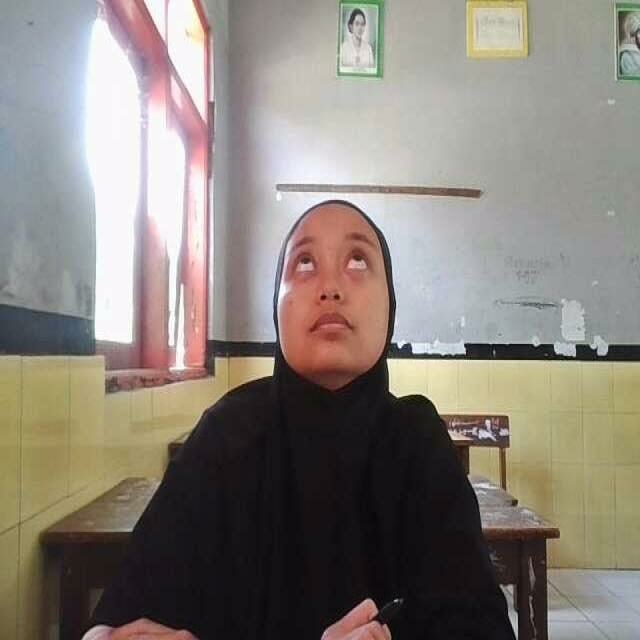

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images = image_generator.next()

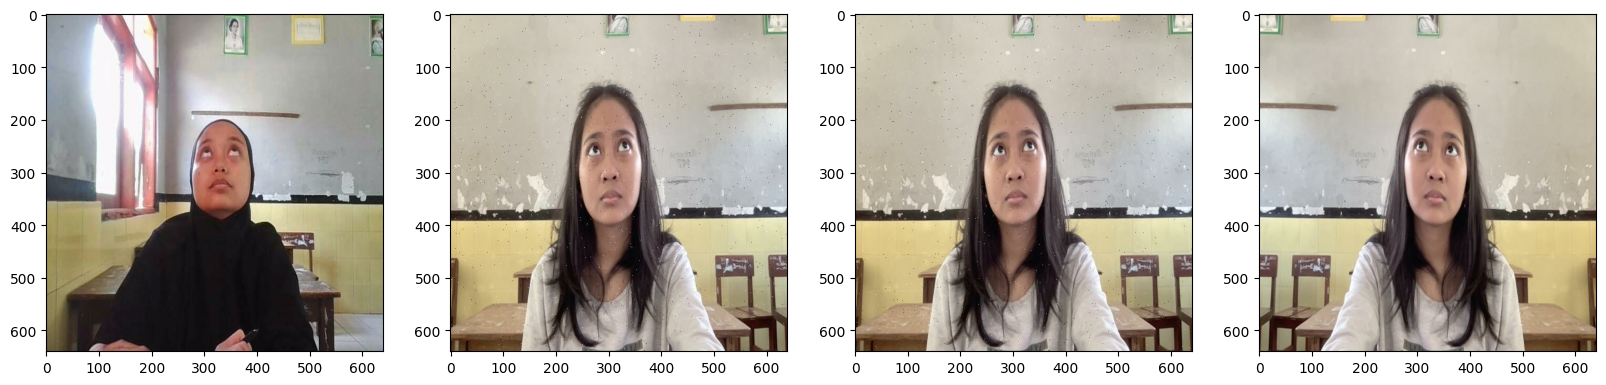

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Partition Unaugmented Data

### 3.1 SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
def split_images(source_dir, train_dir, val_dir, test_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Splits images in a source directory into train, validation, and test sets.

    Args:
        source_dir: Path to the source directory containing images.
        train_dir: Path to the directory for training images.
        val_dir: Path to the directory for validation images.
        test_dir: Path to the directory for test images.
        train_ratio: Proportion of images to allocate to the training set.
        val_ratio: Proportion of images to allocate to the validation set.
        test_ratio: Proportion of images to allocate to the test set.
    """
    # Create target directories if they don't exist
    for dir in [train_dir, val_dir, test_dir]:
        if not os.path.exists(dir):
            os.makedirs(dir)

    # Get a list of all image files in the source directory
    image_files = os.listdir(source_dir)

    # Shuffle the list of image files randomly
    random.shuffle(image_files)

    # Calculate the number of images for each set
    total_images = len(image_files)
    train_size = int(total_images * train_ratio)
    val_size = int(total_images * val_ratio)
    test_size = total_images - train_size - val_size

    # Split the image files into train, validation, and test sets
    train_files = image_files[:train_size]
    val_files = image_files[train_size:train_size+val_size]
    test_files = image_files[train_size+val_size:]

    # Copy images to their respective directories
    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(train_dir, file))
    for file in val_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(val_dir, file))
    for file in test_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(test_dir, file))


In [ ]:
source_up_dir = '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Up'
source_down_dir = '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Down'
source_right_dir = '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Right'
source_left_dir = '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Left'

train_dir = '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/train/images'
val_dir = '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/val/images'
test_dir = '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/test/images'

In [ ]:
split_images(source_up_dir, train_dir, val_dir, test_dir)

In [ ]:
split_images(source_down_dir, train_dir, val_dir, test_dir)

In [ ]:
split_images(source_right_dir, train_dir, val_dir, test_dir)

In [ ]:
split_images(source_left_dir, train_dir, val_dir, test_dir)

In [ ]:
def count_images_in_source_dirs(source_dirs):
    total_images = 0
    for source_dir in source_dirs:
        # Get the number of image files in each source directory
        image_count = len([file for file in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, file))])
        print(f"Number of images in {source_dir}: {image_count}")
        total_images += image_count
    print(f"Total number of images across all source directories: {total_images}")
    return total_images

# Example usage
source_dirs = [
    '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Up',
    '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Down',
    '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Left',
    '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Right'
]

total_images_in_source = count_images_in_source_dirs(source_dirs)


Number of images in /content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Up: 104
Number of images in /content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Down: 108
Number of images in /content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Left: 100
Number of images in /content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/raw/Right: 202
Total number of images across all source directories: 514


In [ ]:
def count_images_in_directory(directory):
    return len([file for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))])

train_image_count = count_images_in_directory(train_dir)
val_image_count = count_images_in_directory(val_dir)
test_image_count = count_images_in_directory(test_dir)

print(f"Training images: {train_image_count}")
print(f"Validation images: {val_image_count}")
print(f"Test images: {test_image_count}")


Training images: 358
Validation images: 76
Test images: 80


In [ ]:
# FOR DEBUGGING PURPOSES
# def delete_all_images(folder_path):
#     """Deletes all images from the specified folder.

#     Args:
#         folder_path: Path to the folder containing images to delete.
#     """
#     # Supported image extensions
#     image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp')

#     # Check if the folder exists
#     if not os.path.exists(folder_path):
#         print(f"The folder '{folder_path}' does not exist.")
#         return

#     # Iterate through all files in the folder
#     for file_name in os.listdir(folder_path):
#         file_path = os.path.join(folder_path, file_name)

#         # Check if the file has an image extension and is a file
#         if os.path.isfile(file_path) and file_name.lower().endswith(image_extensions):
#             os.remove(file_path)
#             print(f"Deleted: {file_path}")

#     print("All images have been deleted.")

In [ ]:
# folder_path = '/path/to/your/folder'
# delete_all_images(folder_path)

### 3.2 Move the Matching Labels

In [ ]:
# Define the base folder paths in Google Drive
base_drive_path = '/content/drive/MyDrive/LivenessDetectionmMobilenet'
source_label_path = os.path.join(base_drive_path, 'dataset', 'labels')

for folder in ['train', 'test', 'val']:
    # Define folder-specific paths
    image_folder = os.path.join(base_drive_path, 'dataset', folder, 'images')
    label_folder = os.path.join(base_drive_path, 'dataset', folder, 'labels')

    # Ensure destination label folder exists
    os.makedirs(label_folder, exist_ok=True)

    # Iterate over images in the current folder
    for file in os.listdir(image_folder):
        # Extract image base name
        image_name = os.path.splitext(file)[0]
        filename = f"{image_name}.json"

        # Paths for source and destination
        existing_filepath = os.path.join(source_label_path, filename)
        new_filepath = os.path.join(label_folder, filename)

        # Check if label file exists
        if os.path.exists(existing_filepath):
            try:
                shutil.copy(existing_filepath, new_filepath)
                print(f"Copied {filename} to {new_filepath}")
            except Exception as e:
                print(f"Error copying {filename}: {e}")
        else:
            print(f"Label file not found for image: {file}")


Copied 43fd26e1b508c9c5_jpg.rf.d7c9e41e4eb33267c911022e705d0431.json to /content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/train/labels/43fd26e1b508c9c5_jpg.rf.d7c9e41e4eb33267c911022e705d0431.json
Copied Terang_Frame_1866_png.rf.b3a7f4760c953e283406f8c4fe79d7ea.json to /content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/train/labels/Terang_Frame_1866_png.rf.b3a7f4760c953e283406f8c4fe79d7ea.json
Copied 1e12d526df960ed2091aeb9f99a80de_jpg.rf.ee333b82d653f78263823d1c0c2a6ed8.json to /content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/train/labels/1e12d526df960ed2091aeb9f99a80de_jpg.rf.ee333b82d653f78263823d1c0c2a6ed8.json
Copied AtasBudeGelap_56_jpg.rf.8cb6b2b7d287ea3234339eeaeed7cd7c.json to /content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/train/labels/AtasBudeGelap_56_jpg.rf.8cb6b2b7d287ea3234339eeaeed7cd7c.json
Copied ce07cc80f1570_jpg.rf.eb1574dff1f73e6effc7c79cb45b0956.json to /content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/train/labels/ce0

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [ ]:
!pip install albumentations
import albumentations as alb

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Updated augmentation pipeline (no bounding boxes)
augmentor = alb.Compose(
    [
        alb.RandomBrightnessContrast(p=0.3),  # Adjust brightness and contrast
        alb.RandomGamma(p=0.3),               # Random gamma correction
        alb.RGBShift(p=0.3),                  # Random RGB channel shifts
        alb.ShiftScaleRotate(                # Subtle shifts, scaling, and rotations
            shift_limit=0.05,
            scale_limit=0.05,
            rotate_limit=10,  # Reduced rotation limit for safety
            p=0.4
        ),
        alb.MotionBlur(blur_limit=3, p=0.2),  # Simulate subtle camera movement
        alb.GaussianBlur(blur_limit=(3, 5), p=0.2),  # Slight blurring
        alb.ISONoise(p=0.2),                  # Mimic realistic noise
        alb.HueSaturationValue(              # Subtle color adjustments
            hue_shift_limit=8,
            sat_shift_limit=15,
            val_shift_limit=8,
            p=0.3
        ),
        alb.Perspective(scale=(0.02, 0.05), p=0.2),  # Very minor perspective distortion
        alb.CLAHE(clip_limit=2, p=0.2),      # Contrast enhancement for clarity
    ]
)


### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [ ]:
# Adjust the path to point to your Drive folder
img_path = os.path.join('/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/train/images', 'Copy of Screenshot 2024-10-01 123239.png')

img = cv2.imread(img_path)
assert img is not None, "Image failed to load. Check the file path."


In [ ]:
# Adjust the path to point to your Drive folder
json_path = os.path.join('/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/train/labels', 'Copy of Screenshot 2024-10-01 123239.json')

with open(json_path, 'r') as f:
    label = json.load(f)


In [ ]:
label['shapes'][0]['label']

'right'

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [ ]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
class_labels = [label['shapes'][0]['label']]  # Add the label


In [ ]:
coords

[228.38016528925607, 95.2685950413223, 667.2231404958677, 760.5578512396694]

In [ ]:
coords = list(np.divide(coords, [640,480,640,480]))

In [ ]:
coords

[0.3568440082644626,
 0.19847623966942146,
 1.0425361570247933,
 1.5844955234159779]

In [ ]:
coords = np.clip(coords, 0.0, 1.0)  # Ensure within [0, 1]


In [ ]:
coords

array([0.35684401, 0.19847624, 1.        , 1.        ])

### 4.4 Apply Augmentations and View Results

In [ ]:
def augment(image, class_labels):
    # Apply augmentations to the image, bounding boxes, and labels
    augmented = augmentor(image=image, class_labels=class_labels)

    # Return the augmented image, bbox, and class labels
    return augmented['image'], augmented['class_labels']

# Example usage:
# Assuming bbox is in the format [x_min, y_min, x_max, y_max] and class_labels contains the associated labels
augmented_image, augmented_class_labels = augment(img, class_labels)


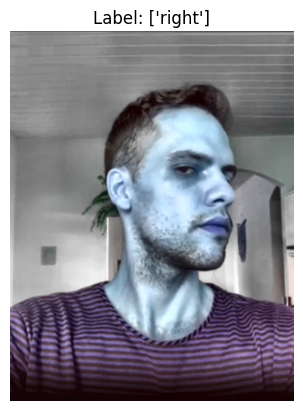

In [ ]:
plt.imshow(augmented_image)
plt.title(f"Label: {class_labels}")
plt.axis('off')
plt.show()

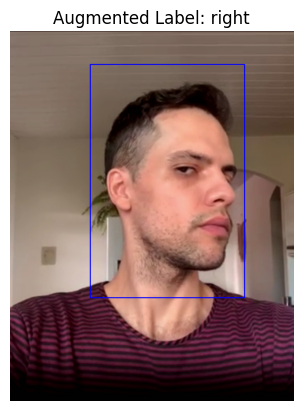

In [ ]:
# Define the base folder in Google Drive
base_drive_path = '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/train'

# Define the augmentation pipeline
augmentor = alb.Compose(
    [
        alb.RandomBrightnessContrast(p=0.3),  # Adjust brightness and contrast
        alb.RandomGamma(p=0.3),               # Random gamma correction
        alb.RGBShift(p=0.3),                  # Random RGB channel shifts
        alb.ShiftScaleRotate(                # Subtle shifts, scaling, and rotations
            shift_limit=0.05,
            scale_limit=0.05,
            rotate_limit=10,  # Reduced rotation limit for safety
            p=0.4
        ),
        alb.MotionBlur(blur_limit=3, p=0.2),  # Simulate subtle camera movement
        alb.GaussianBlur(blur_limit=(3, 5), p=0.2),  # Slight blurring
        alb.ISONoise(p=0.2),                  # Mimic realistic noise
        alb.HueSaturationValue(              # Subtle color adjustments
            hue_shift_limit=8,
            sat_shift_limit=15,
            val_shift_limit=8,
            p=0.3
        ),
        alb.Perspective(scale=(0.02, 0.05), p=0.2),  # Very minor perspective distortion
        alb.CLAHE(clip_limit=2, p=0.2),      # Contrast enhancement for clarity
    ],
    bbox_params=alb.BboxParams(
        format='albumentations',       # BBox format expected by Albumentations
        label_fields=['class_labels'], # Ensure bounding box labels align
    )
)

# Load the image from Google Drive
img = cv2.imread(os.path.join(base_drive_path, 'images', 'Copy of Screenshot 2024-10-01 123239.png'))
assert img is not None, "Image failed to load. Check the file path."

# Load the label from Google Drive
with open(os.path.join(base_drive_path, 'labels', 'Copy of Screenshot 2024-10-01 123239.json'), 'r') as f:
    label = json.load(f)

# Extract bounding box and label
coords = [
    label['shapes'][0]['points'][0][0],  # x_min
    label['shapes'][0]['points'][0][1],  # y_min
    label['shapes'][0]['points'][1][0],  # x_max
    label['shapes'][0]['points'][1][1]   # y_max
]
class_labels = [label['shapes'][0]['label']]  # Add the label

# Normalize bounding box coordinates
height, width = img.shape[:2]
coords = list(np.divide(coords, [width, height, width, height]))  # Normalize to [0, 1]
coords = np.clip(coords, 0.0, 1.0)  # Ensure within [0, 1]

# Apply augmentations
augmented = augmentor(image=img, bboxes=[coords], class_labels=class_labels)

# Extract augmented data
augmented_image = augmented['image']
augmented_bboxes = augmented['bboxes']
augmented_labels = augmented['class_labels']

# Ensure bounding box matches the augmented image dimensions
augmented_height, augmented_width = augmented_image.shape[:2]
bbox_start = tuple(np.multiply(augmented_bboxes[0][:2], [augmented_width, augmented_height]).astype(int))
bbox_end = tuple(np.multiply(augmented_bboxes[0][2:], [augmented_width, augmented_height]).astype(int))

# Draw the bounding box on the augmented image
image_with_bbox = augmented_image.copy()
cv2.rectangle(image_with_bbox, bbox_start, bbox_end, (255, 0, 0), 2)

# Display the augmented image with the bounding box
plt.imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))
plt.title(f"Augmented Label: {augmented_labels[0]}")
plt.axis('off')
plt.show()


# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [ ]:
# Define the folder path
folder_path = '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset/all'

# List of common image extensions (you can modify this as needed)
image_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff']

# Get a list of all files in the folder
files = os.listdir(folder_path)

# Count how many of them are images (i.e., have an image extension)
image_count = sum(1 for file in files if os.path.splitext(file)[1].lower() in image_extensions)

print(f'Total number of images in the folder: {image_count}')


Total number of images in the folder: 514


In [ ]:
# Define base paths in Google Drive
base_drive_path = '/content/drive/MyDrive/LivenessDetectionmMobilenet'
dataset_path = os.path.join(base_drive_path, 'dataset')
augmented_dataset_path = os.path.join(base_drive_path, 'aug_dataset')

# Label mapping
label_mapping = {'up': 0, 'down': 1, 'right': 2, 'left': 3}

# Augment images for each partition
for partition in ['train', 'test', 'val']:
    image_folder = os.path.join(dataset_path, partition, 'images')
    label_folder = os.path.join(dataset_path, partition, 'labels')

    for image in os.listdir(image_folder):
        img_path = os.path.join(image_folder, image)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {image}. Skipping...")
            continue

        label_path = os.path.join(label_folder, f"{os.path.splitext(image)[0]}.json")
        if not os.path.exists(label_path):
            print(f"Label file not found for {image}. Skipping...")
            continue

        # Load label
        with open(label_path, 'r') as f:
            label = json.load(f)

        # Extract the class label (no need for bounding box normalization)
        class_labels = [label['shapes'][0]['label']] if 'shapes' in label and label['shapes'] else []

        if not class_labels:
            print(f"No valid labels in {label_path}. Skipping...")
            continue

        try:
            # Map labels to numerical values
            encoded_labels = [label_mapping[label] for label in class_labels]
        except KeyError as e:
            print(f"Unknown label '{e}' in {label_path}. Skipping...")
            continue

        for x in range(100):  # Generate 10 augmentations per image
            try:
                # Apply augmentations to the image only
                augmented = augmentor(image=img)
                augmented_image = augmented['image']

                # Save augmented image
                aug_image_path = os.path.join(augmented_dataset_path, partition, 'images', f'{image.split(".")[0]}.{x}.jpg')
                os.makedirs(os.path.dirname(aug_image_path), exist_ok=True)
                cv2.imwrite(aug_image_path, augmented_image)

                # Save the corresponding annotation
                annotation = {
                    'image': f'{image.split(".")[0]}.{x}.jpg',
                    'class': encoded_labels[0] if len(encoded_labels) > 0 else 0
                }

                aug_label_path = os.path.join(augmented_dataset_path, partition, 'labels', f'{image.split(".")[0]}.{x}.json')
                os.makedirs(os.path.dirname(aug_label_path), exist_ok=True)
                with open(aug_label_path, 'w') as f:
                    json.dump(annotation, f)

            except Exception as e:
                print(f"Error augmenting {image}: {e}")
                continue


In [ ]:
# Define the base dataset path
dataset_path = '/content/drive/MyDrive/LivenessDetectionmMobilenet/dataset'

# Initialize a dictionary to store file counts
file_counts = {}

# Loop through each partition
for partition in ['train', 'test', 'val']:
    # Define the image and label folder paths
    image_folder = os.path.join(dataset_path, partition, 'images')
    label_folder = os.path.join(dataset_path, partition, 'labels')

    # Count the number of files in each folder
    image_count = len([f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))])
    label_count = len([f for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))])

    # Store the counts in the dictionary
    file_counts[partition] = {
        'images': image_count,
        'labels': label_count
    }

# Print the results
for partition, counts in file_counts.items():
    print(f"{partition.capitalize()} Partition:")
    print(f"  Total Images: {counts['images']}")
    print(f"  Total Labels: {counts['labels']}")
    print()


Train Partition:
  Total Images: 358
  Total Labels: 358

Test Partition:
  Total Images: 80
  Total Labels: 80

Val Partition:
  Total Images: 76
  Total Labels: 76



In [ ]:
# Define the base dataset path
dataset_path = '/content/drive/MyDrive/LivenessDetectionmMobilenet/aug_dataset'

# Initialize a dictionary to store file counts
file_counts = {}

# Loop through each partition
for partition in ['train', 'test', 'val']:
    # Define the image and label folder paths
    image_folder = os.path.join(dataset_path, partition, 'images')
    label_folder = os.path.join(dataset_path, partition, 'labels')

    # Count the number of files in each folder
    image_count = len([f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))])
    label_count = len([f for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))])

    # Store the counts in the dictionary
    file_counts[partition] = {
        'images': image_count,
        'labels': label_count
    }

# Print the results
for partition, counts in file_counts.items():
    print(f"{partition.capitalize()} Partition:")
    print(f"  Total Images: {counts['images']}")
    print(f"  Total Labels: {counts['labels']}")
    print()


Train Partition:
  Total Images: 28600
  Total Labels: 28600

Test Partition:
  Total Images: 7600
  Total Labels: 7600

Val Partition:
  Total Images: 7300
  Total Labels: 7300



### 5.2 Load Augmented Images to Tensorflow Dataset

In [ ]:
train_images = tf.data.Dataset.list_files('/content/drive/MyDrive/LivenessDetectionmMobilenet/aug_dataset/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (224,224)))
train_images = train_images.map(lambda x: x/255)

In [ ]:
test_images = tf.data.Dataset.list_files('/content/drive/MyDrive/LivenessDetectionmMobilenet/aug_dataset/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (224,224)))
test_images = test_images.map(lambda x: x/255)

In [ ]:
val_images = tf.data.Dataset.list_files('/content/drive/MyDrive/LivenessDetectionmMobilenet/aug_dataset/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (224,224)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
train_images.as_numpy_iterator().next()

array([[[0.58505404, 0.60858345, 0.6556423 ],
        [0.5843738 , 0.6079032 , 0.654962  ],
        [0.57310927, 0.5966387 , 0.6436975 ],
        ...,
        [0.5289133 , 0.5053839 , 0.45832506],
        [0.5379153 , 0.52178884, 0.4755704 ],
        [0.49891907, 0.4832328 , 0.44009554]],

       [[0.57753104, 0.60106045, 0.6481193 ],
        [0.57488996, 0.59841937, 0.6454782 ],
        [0.5764906 , 0.60002   , 0.6470788 ],
        ...,
        [0.45154378, 0.44201994, 0.3918799 ],
        [0.5854742 , 0.5763105 , 0.52683073],
        [0.37369135, 0.3658482 , 0.3187894 ]],

       [[0.5758103 , 0.5993397 , 0.64639854],
        [0.59809923, 0.62162864, 0.66868746],
        [0.5716487 , 0.5951781 , 0.64223695],
        ...,
        [0.4125868 , 0.40474367, 0.35376325],
        [0.60274166, 0.5932178 , 0.54699934],
        [0.40047917, 0.3847929 , 0.34949878]],

       ...,

       [[0.46760663, 0.4205478 , 0.25584194],
        [0.5008804 , 0.45382157, 0.2891157 ],
        [0.49289727, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)

    class_label = np.array([label['class']], dtype=np.uint8)
    class_label = np.reshape(class_label, ())

    return class_label


### 6.2 Load Labels to Tensorflow Dataset

In [ ]:
train_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/LivenessDetectionmMobilenet/aug_dataset/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], tf.uint8))

In [ ]:
test_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/LivenessDetectionmMobilenet/aug_dataset/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], tf.uint8))

In [ ]:
val_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/LivenessDetectionmMobilenet/aug_dataset/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], tf.uint8))

In [ ]:
train_labels.as_numpy_iterator().next()

0

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [ ]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(28600, 28600, 7600, 7600, 7300, 7300)

### 7.2 Create Final Datasets (Images/Labels)

In [ ]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(14300)

train = train.map(
    lambda X, y: (
        tf.ensure_shape(tf.cast(X, tf.float32), (224, 224, 3)),
        tf.ensure_shape(tf.cast(y, tf.int32), ())  # Assume 1D tensor for class output
    )
)

train = train.batch(16).prefetch(tf.data.AUTOTUNE)


In [ ]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(3800)

test = test.map(
    lambda X, y: (
        tf.ensure_shape(tf.cast(X, tf.float32), (224, 224, 3)),
        tf.ensure_shape(tf.cast(y, tf.int32), ())  # Assume 1D tensor for class output
    )
)

test = test.batch(16).prefetch(tf.data.AUTOTUNE)


In [ ]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(3650)

val = val.map(
    lambda X, y: (
        tf.ensure_shape(tf.cast(X, tf.float32), (224, 224, 3)),
        tf.ensure_shape(tf.cast(y, tf.int32), ())  # Assume 1D tensor for class output
    )
)

val = val.batch(16).prefetch(tf.data.AUTOTUNE)


### 7.3 View Images and Annotations

In [ ]:
data_samples = train.as_numpy_iterator()

In [ ]:
res = data_samples.next()

Image 1: Label = Up
Image 2: Label = Right
Image 3: Label = Up
Image 4: Label = Right
Image 5: Label = Left
Image 6: Label = Left
Image 7: Label = Right
Image 8: Label = Up
Image 9: Label = Up
Image 10: Label = Right
Image 11: Label = Right
Image 12: Label = Right
Image 13: Label = Right
Image 14: Label = Down
Image 15: Label = Down
Image 16: Label = Right


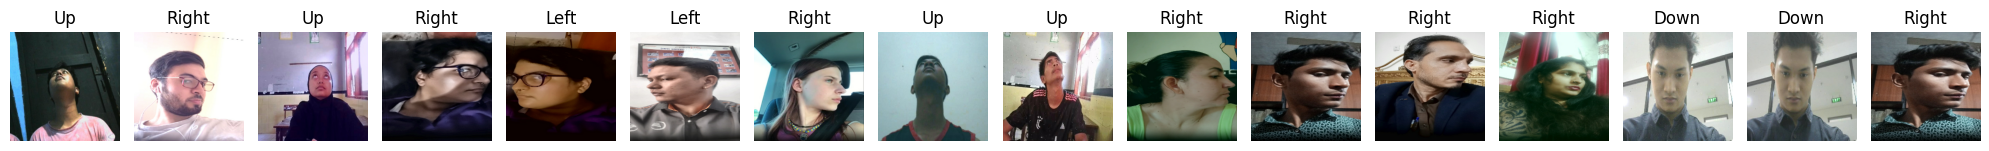

In [ ]:
fig, ax = plt.subplots(ncols=16, figsize=(20, 20))

# Class label mapping (assuming classes: 0="Up", 1="Down", 2="Right", 3="Left")
class_labels = {0: "Up", 1: "Down", 2: "Right", 3: "Left"}

for idx in range(16):
    # Extract image and label
    sample_image = res[0][idx].copy()  # Extract the image (res[0] is the batch of images)
    sample_label = res[1][idx]  # Extract the classification label (res[1] is the batch of labels)

    # Normalize the image for `imshow` (ensure range [0, 255] for uint8)
    if sample_image.dtype != np.uint8:
        sample_image = np.clip(sample_image, 0, 1) * 255
        sample_image = sample_image.astype(np.uint8)

    # Print the label in the console
    print(f"Image {idx+1}: Label = {class_labels[int(sample_label)]}")

    # Display the image and add label as the title
    ax[idx].imshow(sample_image)
    ax[idx].set_title(class_labels[int(sample_label)], fontsize=12, color="black")
    ax[idx].axis('off')  # Hide axes

plt.tight_layout()
plt.show()


# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalMaxPooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf


### 8.2 Download Keras Model


In [ ]:
mobilenet = MobileNetV2(include_top=False)

<ipython-input-36-5138f7bd8ad6>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(include_top=False)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
mobilenet.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, None, None, 32) │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, None, None, 32) │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, None, None, 32) │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, None, None, 32) │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 32) │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, None, None, 16) │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, None, None, 16) │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, None, None, 96) │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, None, None, 96) │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, None, None, 96) │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, None, None, 96) │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, None, None, 96) │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

### 8.3 Build instance of Network

In [ ]:
def build_model():
    input_layer = Input(shape=(224, 224, 3))

    # Replace VGG16 with MobileNetV2
    mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)

    # Optionally freeze the MobileNetV2 layers
    for layer in mobilenet.layers:
        layer.trainable = False

    # Classification Model
    f1 = GlobalMaxPooling2D()(mobilenet.output)
    class1 = Dense(2048, activation='relu')(f1)
    class1 = Dropout(0.5)(class1)
    class_output = Dense(4, activation='softmax')(class1)  # Classification output for up, down, left, right

    # Create the classification-only model
    livenessdetector = Model(inputs=input_layer, outputs=class_output)
    return livenessdetector


### 8.4 Test out Neural Network

In [ ]:
livenessdetector = build_model()

<ipython-input-38-873d54b362eb>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)


In [ ]:
livenessdetector.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 4,889,668 (18.65 MB)

 Trainable params: 2,631,684 (10.04 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

In [ ]:
classes = livenessdetector.predict(X)

In [ ]:
classes

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [ ]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="class_loss", factor=0.5, patience=3, min_lr=1e-6
)


### 9.2 Create Localization Loss and Classification Loss

In [ ]:
def smooth_l1_loss(y_true, y_pred):
    diff = tf.abs(y_true - y_pred)
    less_than_one = tf.cast(diff < 1.0, "float32")
    loss = less_than_one * 0.5 * diff**2 + (1.0 - less_than_one) * (diff - 0.5)
    return tf.reduce_sum(loss)


In [ ]:
classloss = tf.keras.losses.SparseCategoricalCrossentropy()

### 9.3 Test out Loss Metrics

In [ ]:
classloss(y, classes)

<tf.Tensor: shape=(), dtype=float32, numpy=5.216837>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [ ]:
class LivenessDetector(Model):
    def __init__(self, livenessdetector, **kwargs):
        super().__init__(**kwargs)
        self.model = livenessdetector

    def compile(self, opt, classloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.opt = opt
        self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
        self.val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="val_accuracy")

    def train_step(self, batch):
        X, y = batch
        with tf.GradientTape() as tape:
            # Only classification output
            classes = self.model(X, training=True)

            # Compute classification loss
            batch_classloss = self.closs(y, classes)
            total_loss = batch_classloss

        grad = tape.gradient(total_loss, self.model.trainable_variables)
        grad = [tf.clip_by_norm(g, 1.0) for g in grad]  # Using gradient clipping by norm
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

        # Update classification accuracy
        self.train_accuracy.update_state(y, classes)

        return {
            "total_loss": total_loss,
            "class_loss": batch_classloss,
            "accuracy": self.train_accuracy.result(),
        }

    def test_step(self, batch):
        X, y = batch
        # Only classification output
        classes = self.model(X, training=False)

        # Compute classification loss
        batch_classloss = self.closs(y, classes)
        total_loss = batch_classloss

        # Update validation accuracy
        self.val_accuracy.update_state(y, classes)

        return {
            "total_loss": total_loss,
            "class_loss": batch_classloss,
            "accuracy": self.val_accuracy.result(),
        }

    def call(self, inputs):
        return self.model(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({
            'livenessdetector_config': self.model.get_config()  # Store the model configuration
        })
        return config

    @classmethod
    def from_config(cls, config):
        livenessdetector_config = config['livenessdetector_config']
        livenessdetector_model = MobileNetV2.from_config(livenessdetector_config)  # Load the inner model
        return cls(livenessdetector_model)


In [ ]:
model = LivenessDetector(livenessdetector)

In [ ]:
model.compile(
    opt,
    classloss,  # Classification loss
)

### 10.2 Train

In [ ]:
logdir='logs'

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="class_loss",  # Metric to monitor
    patience=10,            # Number of epochs to wait before stopping
    mode="min",            # Specify that the metric should be minimized
    restore_best_weights=True  # Optionally restore the best weights
)


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("accuracy")
        if accuracy is not None and accuracy >= self.threshold:
            print(f"\nStopping training as accuracy reached {self.threshold * 100:.2f}%")
            self.model.stop_training = True

# Use the custom callback
accuracy_callback = AccuracyThresholdCallback(threshold=0.99)  # Stop at 98 accuracy)

In [ ]:
hist = model.fit(
    train,
    epochs=10,
    validation_data=val,
    callbacks=[lr_scheduler, early_stopping, accuracy_callback]
)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 339ms/step - accuracy: 0.3724 - class_loss: 2.9426 - total_loss: 2.9426 - val_accuracy: 0.6027 - val_class_loss: 0.1204 - val_total_loss: 0.1204 - learning_rate: 0.0010
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6626 - class_loss: 1.0898 - total_loss: 1.0898 - val_accuracy: 0.6438 - val_class_loss: 0.8631 - val_total_loss: 0.8631 - learning_rate: 0.0010
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7002 - class_loss: 0.9200 - total_loss: 0.9200 - val_accuracy: 0.6575 - val_class_loss: 0.1601 - val_total_loss: 0.1601 - learning_rate: 0.0010
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8120 - class_loss: 0.6776 - total_loss: 0.6776 - val_accuracy: 0.6986 - val_class_loss: 0.1136 - val_total_loss: 0.1136 - learning_rate: 0.0010
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7520 - class_loss: 0.5760 - total_loss: 0.5760 - val_accuracy: 0.6986 - val_class_loss: 0.1058 - 

### 10.3 Plot Performance

In [ ]:
hist.history

{'accuracy': [0.4440559446811676,
  0.6713286638259888,
  0.7202796936035156,
  0.7797203063964844,
  0.8041958212852478,
  0.8776223659515381,
  0.867132842540741,
  0.9090909361839294,
  0.9265734553337097,
  0.9300699234008789],
 'class_loss': [3.8049209117889404,
  0.42348551750183105,
  1.2187271118164062,
  0.41641443967819214,
  0.8695352077484131,
  0.15572690963745117,
  0.6327683925628662,
  0.007306182757019997,
  0.0003924211487174034,
  0.4230038523674011],
 'total_loss': [3.8049209117889404,
  0.42348551750183105,
  1.2187271118164062,
  0.41641443967819214,
  0.8695352077484131,
  0.15572690963745117,
  0.6327683925628662,
  0.007306182757019997,
  0.0003924211487174034,
  0.4230038523674011],
 'val_accuracy': [0.6027397513389587,
  0.6438356041908264,
  0.6575342416763306,
  0.698630154132843,
  0.698630154132843,
  0.6712328791618347,
  0.6712328791618347,
  0.698630154132843,
  0.698630154132843,
  0.7260273694992065],
 'val_class_loss': [0.12037145346403122,
  0.8631

In [ ]:
# fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

# # Access the single tensor value in each list and convert it to numpy before plotting
# ax[0].plot([hist.history['total_loss'][0].numpy()], color='teal', label='loss')
# ax[0].plot([hist.history['val_total_loss'][0].numpy()], color='orange', label='val loss')
# ax[0].title.set_text('Loss')
# ax[0].legend()

# ax[1].plot([hist.history['class_loss'][0].numpy()], color='teal', label='class loss')
# ax[1].plot([hist.history['val_class_loss'][0].numpy()], color='orange', label='val class loss')
# ax[1].title.set_text('Classification Loss')
# ax[1].legend()

# ax[2].plot([hist.history['regress_loss'][0].numpy()], color='teal', label='regress loss')
# ax[2].plot([hist.history['val_regress_loss'][0].numpy()], color='orange', label='val regress loss')
# ax[2].title.set_text('Regression Loss')
# ax[2].legend()

# plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Extract the history data
history = hist.history

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Total Loss
plt.subplot(1, 2, 2)
plt.plot(history['total_loss'], label='Training Loss')
plt.plot(history['val_total_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()
yhat = model.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


['Up (1.00)', 'Right (1.00)', 'Right (1.00)', 'Right (1.00)']


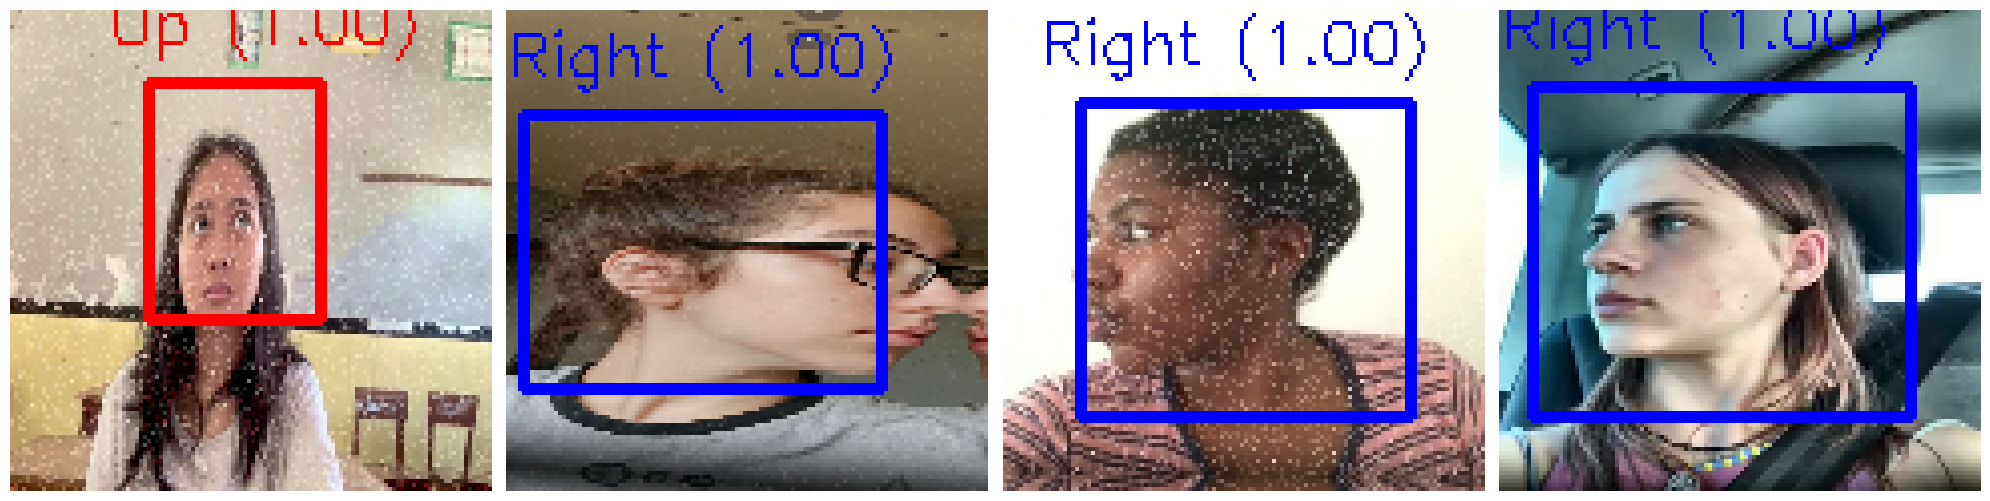

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
label = []

# Confidence threshold
confidence_threshold = 0.8

for idx in range(4):
    # Make a writable copy of the image
    sample_image = test_sample[0][idx].copy()
    sample_coords = yhat[1][idx]

    # Predicted class (0, 1, 2, 3 for "up", "down", "right", "left")
    predicted_class = np.argmax(yhat[0][idx])  # Assuming yhat[0][idx] contains class probabilities
    confidence = yhat[0][idx][predicted_class]  # Confidence of the predicted class

    # Map predicted class to labels and rectangle colors
    class_labels = {0: "Up", 1: "Down", 2: "Right", 3: "Left"}
    rectangle_colors = {0: (255, 0, 0), 1: (0, 255, 0), 2: (0, 0, 255), 3: (255, 255, 0)}  # Colors for each class

    # Draw rectangle and label only if confidence exceeds the threshold
    if confidence > confidence_threshold:
        start_point = tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int))
        end_point = tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int))

        # Draw bounding box
        cv2.rectangle(
            sample_image,
            start_point,
            end_point,
            rectangle_colors[predicted_class],
            2
        )
        # Add class label to the image
        cv2.putText(
            sample_image,
            f"{class_labels[predicted_class]} ({confidence:.2f})",
            (max(start_point[0] - 10, 0), max(start_point[1] - 10, 0)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            rectangle_colors[predicted_class],
            1
        )
        label.append(f"{class_labels[predicted_class]} ({confidence:.2f})")
    else:
        # If confidence is too low, skip drawing but append "No detection" to label
        label.append("No detection")

    # Plot the image
    ax[idx].imshow(sample_image)
    ax[idx].axis("off")

# Display the predictions
print(label)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


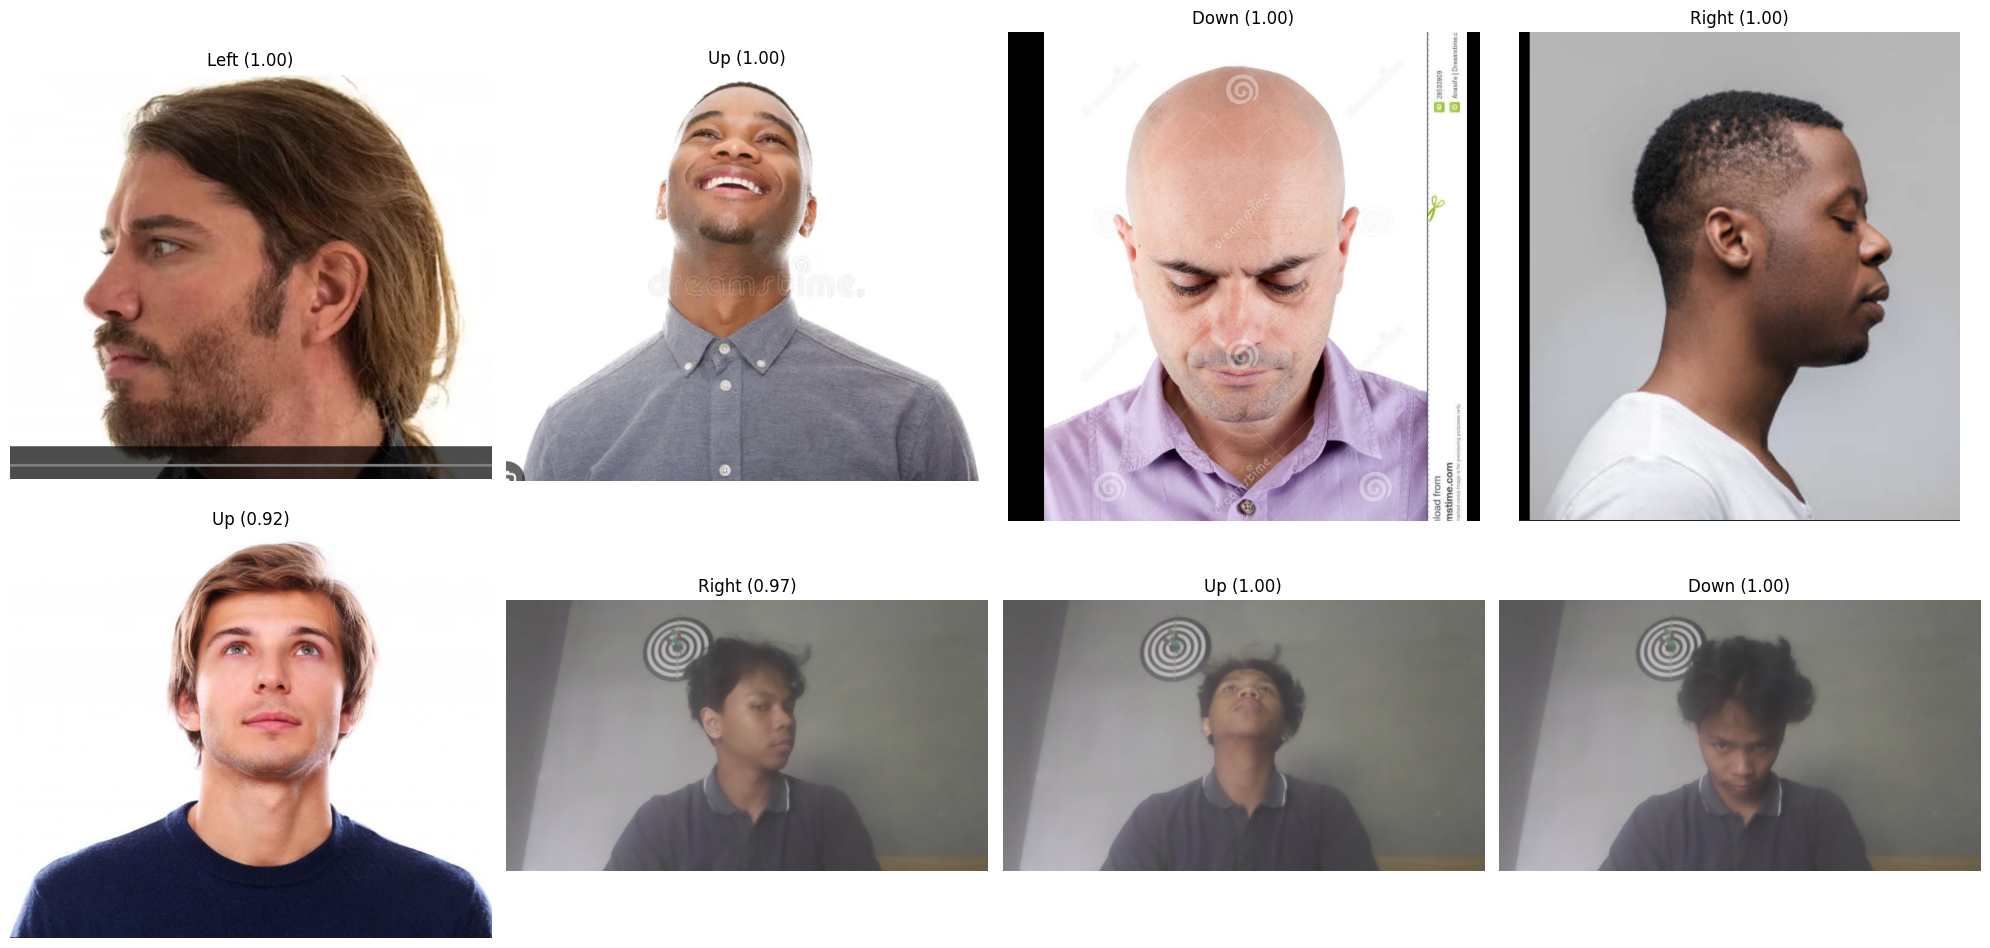

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math

# Path to the folder containing the images
folder_path = "D:/UNS/Kuliah/Semester 5/Bangkit/LivenessDetection2/dataset/new faces"

# Load all image file paths in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

if len(image_files) == 0:
    print("No images found in the folder!")
else:
    # Predict for all images in the folder
    labels = []  # To store labels for the predictions
    predictions = []  # To store processed images for visualization

    for image_file in image_files:
        img_path = os.path.join(folder_path, image_file)

        # Load the image
        img = cv2.imread(img_path)

        if img is None:
            print(f"Failed to load {image_file}. Skipping...")
            continue

        original_height, original_width = img.shape[:2]

        # Preprocess the image
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, (120, 120))
        img_normalized = img_resized / 255.0
        img_batch = np.expand_dims(img_normalized, axis=0)

        # Predict
        yhat = model.predict(img_batch)
        predicted_class = np.argmax(yhat[0][0])  # Assuming yhat[0] contains class probabilities
        confidence = yhat[0][0][predicted_class]

        class_labels = {0: "Up", 1: "Down", 2: "Right", 3: "Left"}

        # Add label if confidence exceeds threshold
        confidence_threshold = 0.5
        if confidence > confidence_threshold:
            labels.append(f"{class_labels[predicted_class]} ({confidence:.2f})")
        else:
            labels.append("No detection")

        predictions.append(img_rgb)

    # Determine grid layout
    num_images = len(predictions)
    cols = 4  # Number of columns
    rows = math.ceil(num_images / cols)

    fig, ax = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    ax = ax.ravel()  # Flatten the axes array for easier indexing

    for idx, image in enumerate(predictions):
        ax[idx].imshow(image)
        ax[idx].axis("off")
        ax[idx].set_title(labels[idx])

    # Hide unused axes
    for i in range(len(predictions), len(ax)):
        ax[i].axis("off")

    plt.tight_layout()
    plt.show()


### 11.2 Save the Model

In [ ]:
model.save("LivenessDetectionMobileNet1.h5")


In [ ]:
import tensorflow as tf

# Assuming `livenessdetector` is your trained model
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('LivenessDetectionV2.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\rafly\AppData\Local\Temp\tmpor1ctdgg\assets


INFO:tensorflow:Assets written to: C:\Users\rafly\AppData\Local\Temp\tmpor1ctdgg\assets


Saved artifact at 'C:\Users\rafly\AppData\Local\Temp\tmpor1ctdgg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None)
Output Type:
  List[TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)]
Captures:
  2127315340560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2127315343056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2127315343248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2127315342864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2127315342288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2127315343632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2127315344976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2127315345168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2127315344784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2127315344016: Tens

In [ ]:
import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support.metadata_schema_py_generated import ModelMetadataT, TensorMetadataT, SubGraphMetadataT, StatsT, ProcessUnitT, NormalizationOptionsT, ContentT, ImagePropertiesT
from tflite_support.metadata_schema_py_generated import ColorSpaceType, ContentProperties, ProcessUnitOptions

def create_metadata():
    # Create a FlatBuffer builder
    builder = flatbuffers.Builder(1024)

    # Model metadata
    model_meta = ModelMetadataT()
    model_meta.name = "Liveness Detector"
    model_meta.description = "Model to detect liveness and predict face orientation"
    model_meta.version = "v1.0.0"
    model_meta.author = "Rafly Amanta Haryanto"

    # Input metadata (image input)
    input_meta = TensorMetadataT()
    input_meta.name = "input"
    input_meta.description = "Input image to the model, expected size is 120x120x3 (RGB)."
    input_meta.content = ContentT()
    input_meta.content.contentProperties = ImagePropertiesT()
    input_meta.content.contentProperties.colorSpace = ColorSpaceType.RGB
    input_meta.content.contentPropertiesType = ContentProperties.ImageProperties

    # Normalization process for input images
    input_normalization = ProcessUnitT()
    input_normalization.optionsType = ProcessUnitOptions.NormalizationOptions
    input_normalization.options = NormalizationOptionsT()
    input_normalization.options.mean = [127.5]  # Mean value for normalization
    input_normalization.options.std = [127.5]   # Standard deviation for normalization
    input_meta.processUnits = [input_normalization]

    # Input stats
    input_stats = StatsT()
    input_stats.max = [255.0]
    input_stats.min = [0.0]
    input_meta.stats = input_stats

    # Output metadata (classification output)
    output_class_meta = TensorMetadataT()
    output_class_meta.name = "class_output"
    output_class_meta.description = "Predicted face orientation classes (up, down, left, right)"
    output_class_meta.content = ContentT()
    output_class_meta.content.contentPropertiesType = ContentProperties.FeatureProperties

    # Output stats for class predictions
    output_class_stats = StatsT()
    output_class_stats.max = [1.0]
    output_class_stats.min = [0.0]
    output_class_meta.stats = output_class_stats

    # Output metadata for bounding box regression (if needed)
    output_bbox_meta = TensorMetadataT()
    output_bbox_meta.name = "bbox_output"
    output_bbox_meta.description = "Bounding box regression output"
    output_bbox_meta.content = ContentT()
    output_bbox_meta.content.contentPropertiesType = ContentProperties.FeatureProperties

    # Create subgraph metadata
    subgraph_meta = SubGraphMetadataT()
    subgraph_meta.inputTensorMetadata = [input_meta]
    subgraph_meta.outputTensorMetadata = [output_class_meta, output_bbox_meta]
    model_meta.subgraphMetadata = [subgraph_meta]

    # Serialize metadata to a FlatBuffer
    builder.Finish(model_meta.Pack(builder), _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
    metadata_buf = builder.Output()

    return metadata_buf


In [ ]:
%pip install flatbuffers


In [ ]:
import tflite_support

In [ ]:
!pip install tensorflow



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import flatbuffers
import tensorflow as tf  # For loading and inspecting the TFLite model
from tflite_support import metadata as _metadata
from tflite_support.metadata_schema_py_generated import ModelMetadataT, TensorMetadataT, SubGraphMetadataT, StatsT, ProcessUnitT, NormalizationOptionsT, ContentT, ImagePropertiesT
from tflite_support.metadata_schema_py_generated import ColorSpaceType, ContentProperties, ProcessUnitOptions

def get_model_input_output_details(model_file):
    # Load the TFLite model
    interpreter = tf.lite.Interpreter(model_path=model_file)
    interpreter.allocate_tensors()

    # Get input details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    return input_details, output_details

def create_metadata(model_file):
    # Get input/output details from the model
    input_details, output_details = get_model_input_output_details(model_file)

    # Assuming there's only one input/output for simplicity
    input_info = input_details[0]
    output_class_info = output_details[0]  # Assuming the first output is for class prediction
    output_bbox_info = output_details[1]  # Assuming the second output is for bounding boxes (regression)

    # Create a FlatBuffer builder
    builder = flatbuffers.Builder(1024)

    # Model metadata
    model_meta = ModelMetadataT()
    model_meta.name = "Liveness Detector"
    model_meta.description = "Model to detect liveness and predict bounding boxes"
    model_meta.version = "v1.0.0"
    model_meta.author = "Rafly Amanta Haryanto"

    # Input metadata (based on the model input details)
    input_meta = TensorMetadataT()
    input_meta.name = "input"
    input_meta.description = (
        f"Input image to the model, expected size is {input_info['shape'][1]}x{input_info['shape'][2]}x{input_info['shape'][3]} (RGB)."
    )
    input_meta.content = ContentT()
    input_meta.content.contentProperties = ImagePropertiesT()
    input_meta.content.contentProperties.colorSpace = ColorSpaceType.RGB
    input_meta.content.contentPropertiesType = ContentProperties.ImageProperties

    # Add normalization process (mean and std)
    input_normalization = ProcessUnitT()
    input_normalization.optionsType = ProcessUnitOptions.NormalizationOptions
    input_normalization.options = NormalizationOptionsT()
    input_normalization.options.mean = [127.5]
    input_normalization.options.std = [127.5]
    input_meta.processUnits = [input_normalization]

    # Input stats (max, min values)
    input_stats = StatsT()
    input_stats.max = [255.0]
    input_stats.min = [0.0]
    input_meta.stats = input_stats

    # Output metadata for class prediction
    output_class_meta = TensorMetadataT()
    output_class_meta.name = "class_output"
    output_class_meta.description = "Predicted classes (up, down, right, left)"
    output_class_meta.content = ContentT()
    output_class_meta.content.contentPropertiesType = ContentProperties.FeatureProperties

    # Output stats for class probabilities
    output_class_stats = StatsT()
    output_class_stats.max = [1.0]
    output_class_stats.min = [0.0]
    output_class_meta.stats = output_class_stats

    # Output metadata for bounding box regression
    output_bbox_meta = TensorMetadataT()
    output_bbox_meta.name = "bbox_output"
    output_bbox_meta.description = "Bounding box regression output"
    output_bbox_meta.content = ContentT()
    output_bbox_meta.content.contentPropertiesType = ContentProperties.FeatureProperties

    # Create SubGraph metadata
    subgraph_meta = SubGraphMetadataT()
    subgraph_meta.inputTensorMetadata = [input_meta]
    subgraph_meta.outputTensorMetadata = [output_class_meta, output_bbox_meta]
    model_meta.subgraphMetadata = [subgraph_meta]

    # Serialize the metadata to a FlatBuffer
    builder.Finish(model_meta.Pack(builder), _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
    metadata_buf = builder.Output()

    # Return the serialized metadata buffer
    return metadata_buf


def populate_metadata(model_file: str):
    metadata_buf = create_metadata(model_file)

    # Load the model file and populate it with metadata
    populator = _metadata.MetadataPopulator.with_model_file(model_file)
    populator.load_metadata_buffer(metadata_buf)

    # If you have associated files (e.g., label files), you can add them here
    # populator.load_associated_files(["path_to_your_label_file.txt"])

    populator.populate()

    print(f"Metadata has been added to {model_file}")

    # Optionally display the metadata in JSON format for validation
    displayer = _metadata.MetadataDisplayer.with_model_file(model_file)
    metadata_json = displayer.get_metadata_json()
    print(f"Metadata JSON:\n{metadata_json}")

    # Optionally save the metadata as a JSON file
    with open("metadata2.json", "w") as json_file:
        json_file.write(metadata_json)


if __name__ == "__main__":
    model_path = "liveness_detector_model.tflite"  # Path to your TFLite model
    populate_metadata(model_path)


In [ ]:
pyenv install 3.11


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math

# Path to the folder containing the images
folder_path = "D:/UNS/Kuliah/Semester 5/Bangkit/LivenessDetection2/dataset/new faces"

class LivenessDetector(Layer):
    def __init__(self, **kwargs):
        super(LivenessDetector, self).__init__(**kwargs)
        # Initialize layer parameters if needed

    def build(self, input_shape):
        # Define the layer's weights and initialization
        pass

    def call(self, inputs):
        # Define the layer's forward pass
        return inputs


# Path to the saved model
model_path = "livenessdetectionV6.h5"

# Load the model with the custom object
livenessdetector = load_model(model_path, custom_objects={"LivenessDetector": LivenessDetector})

# Load all image file paths in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

if len(image_files) == 0:
    print("No images found in the folder!")
else:
    # Predict for all images in the folder
    labels = []  # To store labels for the predictions
    predictions = []  # To store processed images for visualization

    for image_file in image_files:
        img_path = os.path.join(folder_path, image_file)

        # Load the image
        img = cv2.imread(img_path)

        if img is None:
            print(f"Failed to load {image_file}. Skipping...")
            continue

        original_height, original_width = img.shape[:2]

        # Preprocess the image
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, (120, 120))  # Assuming model input size is 120x120
        img_normalized = img_resized / 255.0  # Normalize pixel values to [0, 1]
        img_batch = np.expand_dims(img_normalized, axis=0)  # Add batch dimension

        # Predict
        yhat = livenessdetector.predict(img_batch)
        predicted_class = np.argmax(yhat[0][0])  # Assuming yhat[0] contains class probabilities
        confidence = yhat[0][0][predicted_class]

        class_labels = {0: "Up", 1: "Down", 2: "Right", 3: "Left"}

        # Add label if confidence exceeds threshold
        confidence_threshold = 0.6
        if confidence > confidence_threshold:
            labels.append(f"{class_labels[predicted_class]} ({confidence:.2f})")
        else:
            labels.append("No detection")

        predictions.append(img_rgb)

    # Determine grid layout
    num_images = len(predictions)
    cols = 4  # Number of columns
    rows = math.ceil(num_images / cols)

    fig, ax = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    ax = ax.ravel()  # Flatten the axes array for easier indexing

    for idx, image in enumerate(predictions):
        ax[idx].imshow(image)
        ax[idx].axis("off")
        ax[idx].set_title(labels[idx])

    # Hide unused axes
    for i in range(len(predictions), len(ax)):
        ax[i].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
livenessdetector.export('./model1')

In [ ]:
livenessdetector.save('livenessdetectionV3.h5')

In [ ]:
livenessdetector = load_model('livenessdetection.h5')

In [ ]:
import tensorflow as tf
# Convert to TFLite with DynamicRange Quantize
converter = tf.lite.TFLiteConverter.from_saved_model("./model1")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

# Save the model.
with open('/model.tflite1', 'wb') as f:
  f.write(tflite_quant_model)


In [ ]:
import os

os.path.getsize('/model.tflite1')/float(2**20)

In [ ]:
interpreter = tf.lite.Interpreter(model_path = '/model.tflite1')
interpreter.allocate_tensors()

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
print(input_details)
print(output_details)

In [ ]:
input_details[0]

In [ ]:
from PIL import Image
import numpy as np
image1 = Image.open("D:/UNS/Kuliah/Semester 5/Bangkit/LivenessDetection2/aug_dataset/train/images/Top-view_-Braid-headband__jpeg.3.jpg")
image1 = image1.resize((120,120), 1)
image1 = np.asarray(image1,dtype=np.float32)
image1 = np.expand_dims(image1, axis=0)


In [ ]:
import time

time_start = time.perf_counter()
input_shape = input_details[0]['shape']
input_data1 = image1
interpreter.set_tensor(input_details[0]['index'], input_data1)
interpreter.invoke()
output_data1 = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data1[0])
time_end = time.perf_counter()
time_finish = time_end - time_start

print(time_finish)
print(predicted_class)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="/model.tflite1")  # Path to your TFLite model
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare images for testing
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
label = []

# Confidence threshold
confidence_threshold = 0.5

# Test samples (replace this with your actual test sample data)
test_sample_images = test_sample[0]  # Assuming test_sample[0] is the image batch
test_sample_coords = test_sample[1]  # Assuming test_sample[1] contains the coordinates

# Loop through test samples
for idx in range(4):  # Adjust the range if you want to test more images
    # Prepare the image for inference (resize and normalize if needed)
    sample_image = test_sample_images[idx].copy()  # Copy original image for visualization
    input_image = np.expand_dims(sample_image, axis=0).astype(np.float32)  # Add batch dimension

    # Perform inference using TFLite
    interpreter.set_tensor(input_details[0]['index'], input_image)
    interpreter.invoke()

    # Extract predictions
    yhat_class = interpreter.get_tensor(output_details[0]['index'])  # Class predictions
    yhat_coords = interpreter.get_tensor(output_details[1]['index'])  # Coordinates

    # Predicted class and confidence
    predicted_class = np.argmax(yhat_class[0])  # Assuming batch size = 1
    confidence = yhat_class[0][predicted_class]

    # Map predicted class to labels and rectangle colors
    class_labels = {0: "Up", 1: "Down", 2: "Right", 3: "Left"}
    rectangle_colors = {
        0: (255, 0, 0),
        1: (0, 255, 0),
        2: (0, 0, 255),
        3: (255, 255, 0)
    }  # Colors for each class

    # Draw rectangle and label only if confidence exceeds the threshold
    if confidence > confidence_threshold:
        sample_coords = yhat_coords[0]  # Assuming batch size = 1
        start_point = tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int))
        end_point = tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int))

        # Draw bounding box
        cv2.rectangle(
            sample_image,
            start_point,
            end_point,
            rectangle_colors[predicted_class],
            2
        )
        # Add class label to the image
        cv2.putText(
            sample_image,
            f"{class_labels[predicted_class]} ({confidence:.2f})",
            (max(start_point[0] - 10, 0), max(start_point[1] - 10, 0)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            rectangle_colors[predicted_class],
            1
        )
        label.append(f"{class_labels[predicted_class]} ({confidence:.2f})")
    else:
        # If confidence is too low, skip drawing but append "No detection" to label
        label.append("No detection")

    # Plot the image
    ax[idx].imshow(sample_image)
    ax[idx].axis("off")

# Display the predictions
print(label)
plt.tight_layout()
plt.show()


### 11.3 Saving the Model and Convert it to TFLite

### 11.4 Real Time Detection

In [ ]:
import cv2
print(cv2.getBuildInformation())


In [ ]:
%pip uninstall opencv-python opencv-python-headless


In [ ]:
%pip install opencv-python


In [ ]:
import cv2

# Initialize the camera (0 for the default camera, 1 for an external camera)
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open camera.")
    exit()

while True:
    # Capture a frame
    ret, frame = cap.read()

    # Check if the frame was captured successfully
    if not ret:
        print("Failed to capture frame. Exiting...")
        break

    # Display the frame
    cv2.imshow('Camera Feed', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close any open windows
cap.release()
cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Class labels and corresponding rectangle colors
class_labels = {0: "Up", 1: "Down", 2: "Right", 3: "Left"}
rectangle_colors = {0: (255, 0, 0), 1: (0, 255, 0), 2: (0, 0, 255), 3: (255, 255, 0)}

# Confidence threshold
confidence_threshold = 0.9

# Start video capture
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()

    # Check if the frame was captured successfully
    if not ret or frame is None:
        print("Frame capture failed!")
        break

    # Crop frame
    frame = frame[50:500, 50:500, :]

    # Validate frame dimensions after cropping
    if frame.size == 0:
        print("Cropped frame is empty!")
        break

    # Convert frame to RGB and resize to the model input size
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))

    # Make prediction
    yhat = livenessdetector.predict(np.expand_dims(resized / 255.0, axis=0))
    sample_coords = yhat[1][0]

    # Get the predicted class and its confidence
    predicted_class = np.argmax(yhat[0][0])  # Assuming yhat[0] is a batch with probabilities
    confidence = yhat[0][0][predicted_class]  # Confidence score for the predicted class

    if confidence > confidence_threshold:
        # Draw bounding box for the face
        start_point = tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int))
        end_point = tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int))
        cv2.rectangle(frame, start_point, end_point, rectangle_colors[predicted_class], 2)

        # Draw label with predicted class and confidence
        label_position = tuple(np.add(start_point, [0, -10]))  # Position above the bounding box
        cv2.putText(
            frame,
            f"{class_labels[predicted_class]} ({confidence:.2f})",
            label_position,
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            rectangle_colors[predicted_class],
            2,
            cv2.LINE_AA,
        )

    # Show the frame with bounding boxes and labels
    cv2.imshow('Face Direction', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
del cap  # Explicitly delete the video capture object
gc.collect()  # Force garbage collection to clean up resources


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the liveness detection model
model_path = 'livenessdetectionV2.h5'
livenessdetector = tf.keras.models.load_model(model_path)

# Class labels and corresponding rectangle colors
class_labels = {0: "Up", 1: "Down", 2: "Right", 3: "Left"}

# Confidence threshold
confidence_threshold = 0.5

# Load the image from your computer (replace 'your_image.jpg' with the actual file path)
img_path = 'C:/Users/rafly/OneDrive/Pictures/Camera Roll/WIN_20241206_08_06_16_Pro.jpg'
img = cv2.imread(img_path)

# Check if the image was loaded successfully
if img is None:
    print("Image not found!")
else:
    # Convert the image to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image to the input size expected by the model (120x120 in this case)
    img_resized = cv2.resize(img_rgb, (120, 120))

    # Normalize the image (convert pixel values from [0, 255] to [0, 1])
    img_normalized = img_resized / 255.0

    # Add a batch dimension (model expects shape [batch_size, height, width, channels])
    img_batch = np.expand_dims(img_normalized, axis=0)

    # Make prediction
    yhat = livenessdetector.predict(img_batch)

    # Get the predicted class and confidence
    predicted_class = np.argmax(yhat[0][0])  # Assuming yhat[0] is a batch with probabilities
    confidence = yhat[0][0][predicted_class]  # Confidence score for the predicted class

    # Output prediction result
    if confidence > confidence_threshold:
        prediction_text = f"Predicted direction: {class_labels[predicted_class]} with confidence: {confidence:.2f}"
    else:
        prediction_text = "Prediction confidence below the threshold!"

    # Print the prediction result
    print(prediction_text)

    # Display the image with matplotlib
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)  # Show the image in RGB format
    plt.title(prediction_text)  # Add the prediction result as the title
    plt.axis('off')  # Hide the axis
    plt.show()
